# Laboratorium 4 (Część I) - Podstawowe transformacje geometryczne

W ramach laboratorium zostaną zaimplementowane podstawowe sposoby transformacji geomerycznych obrazu: transformacja sztywna oraz transformacja oparta o tzw. gęste pole deformacji.
Zostanie również zaimplementowana własna funkcja do interpolacji dwuliniowej.

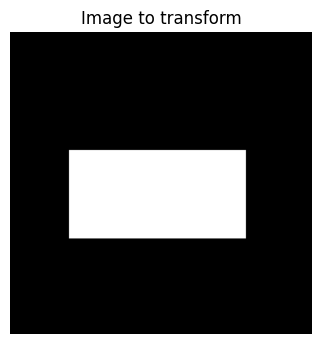

In [ ]:
import numpy as np
from scipy import ndimage as nd
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
%matplotlib inline

y_size, x_size = 1024, 1024
image = np.zeros((y_size, x_size))
image[400:700, 200:800] = 1
plt.figure(dpi=100)
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.title("Image to transform")
plt.show()

Pierwszym zadaniem jest implementacja funkcji generującej macierz transformacji sztywnej (0.5p). Przyjmij, żę generujemy macierz homogeniczną 3x3, a nie oddzielną macierz rotacji i wektor translacji.

In [ ]:
def gen_rigid_matrix(xt, yt, rot):
    """
    xt - translacja po kolumnach
    yt - translacja po wierszach
    rot - rotacja (w stopniach)
    """
    rot = np.radians(rot)

    r_transform = np.array ([
                   [np.cos(rot), -np.sin(rot), xt],
                   [np.sin(rot), np.cos(rot), yt],
                   [0, 0, 1]])


    return r_transform

Przykładowy wynik działania funkcji:

In [ ]:
rigid_matrix = gen_rigid_matrix(50, 50, 45)
print("Rigid matrix: ")
print(rigid_matrix)

Rigid matrix: 
[[ 0.70710678 -0.70710678 50.        ]
 [ 0.70710678  0.70710678 50.        ]
 [ 0.          0.          1.        ]]


Kolejnym krokiem jest implementacja funkcji do transformacji sztywnej (1p).

Funkcja będzie potrzebowała dwóch funkcji pomocnicznych:

1) Funkcji, która będzie modyfikować wygenerowaną macierz transformacji tak, aby następowała ona względem środka obrazu.

2) Funkcji, która dokona transformacji geometrycznej koordynatów korzystając z wycentrowanej macierzy transformacji sztywnej.

Na ten moment do interpolacji wykorzystaj gotową funkcje z pakietu scipy.ndimage.

In [1]:
def center_matrix(transform, x_size, y_size): 
 #Równanie P' = T(x,y)*R*T(-x,-y)*P, pierwsza operacja to T(-x,-y), później R, później T(x,y) P to macierz = [x, y, 1]
 #R macierz rotacji 
 #Bierzemy pod uwagę tylko pierwsze 3 mnożenia z równania i je musimy zaimplementować
 #Operacje wykonywane od prawej do lewej 
    """
    transform - macierz transformacji sztywnej (3x3)
    x_size - liczba kolumn obrazu
    y_size = liczba wierszy obrazu
    """ 
    x_origin = (x_size-1)/2
    y_origin = (y_size-1)/2

    T = np.array([[1, 0, -x_origin],
                  [0, 1, -y_origin],
                  [0, 0, 1]])
 
    T_1 = np.array([[1, 0, x_origin],
                    [0,1, y_origin],
                    [0, 0, 1]])

    result = T_1 @ transform @ T   #@ - operator mnożenia macierzowego 


    return result

In [ ]:
def rigid_dot(grid_x, grid_y, transform):
    """
    grid_x - siatka po kolumnach (YxX)
    grid_y - siatka po wierszach (YxX)
    transform - macierz transformacji sztywnej (3x3)
    """

    coords = np.array([grid_x.ravel(), 
                       grid_y.ravel(), 
                       np.ones(grid_x.size)])
    
    new_coords = transform @ coords

    new_gird_x = new_coords[0].reshape((grid_x.shape))
    new_gird_y = new_coords[1].reshape((grid_y.shape))


    return new_gird_x, new_gird_y

In [ ]:
def rigid_transform(image, transform):
    """
    image - obraz do transformacji (YxX)
    transform - macierz transformacji sztywnej (3x3)
    """
    x_size, y_size = image.shape

    T = center_matrix(transform, x_size, y_size)

    grid_x, grid_y  = np.meshgrid(np.arange(x_size), np.arange(y_size))

    new_grid_x, new_grid_y = rigid_dot(grid_x, grid_y, T)

    transformed_image = nd.map_coordinates(image, [new_grid_x, new_grid_y])
    return transformed_image

#Algorytm do ostatniego zadania #MAPOWANIE
1. określenie rozmiarów obrazu wyjściowego (y_size, x_size)
2. zmodyfikowac macierz transform tak aby oś obrotu była względem środka obrazu (funkcja center_matrix)
3. zbudować grid obrazka (funkcja np.meshgrid z parametrami np.arange(x_size), np.arange(y_size))
4. określić nowy, obrócony grid funkcją rigid_dot z odwróconą macierzą transform 
5. przemapować koordynaty na bazie obrazka wejściowego (funkcja nd.map_coordinates)


Wyniki działania poszczególnych kroków:

Przektszałcenie macierzy względem środka obrazu:

In [ ]:
centered_matrix = center_matrix(rigid_matrix, x_size, y_size)
print("Centered rigid matrix: ")
print(centered_matrix)

Centered rigid matrix: 
[[   0.70710678   -0.70710678  561.5       ]
 [   0.70710678    0.70710678 -161.87023715]
 [   0.            0.            1.        ]]


Transformacja koordynatów za pomocą macierzy sztywnej:

In [ ]:
grid_x = np.array([
    [0, 1, 2],
    [0, 1, 2],
    [0, 1, 2]])

grid_y = np.array([
    [0, 0, 0],
    [1, 1, 1],
    [2, 2, 2]])

temp_transform = np.array([
    [1, 0, 1],
    [0, 1, -1],
    [0, 0, 0]])

new_grid_x, new_grid_y = rigid_dot(grid_x, grid_y, temp_transform)
print("Transformed grids: ")
print(new_grid_x)
print(new_grid_y)

Transformed grids: 
[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]
[[-1. -1. -1.]
 [ 0.  0.  0.]
 [ 1.  1.  1.]]


Rezultat transformacji sztywnej:

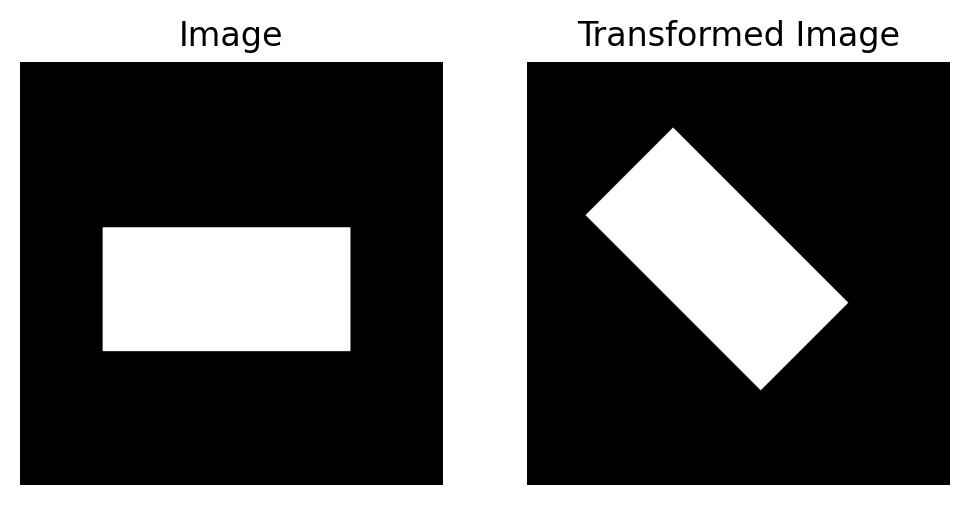

In [ ]:
transformed_image = rigid_transform(image, rigid_matrix)
plt.figure(dpi=200)
plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Image")
plt.subplot(1, 2, 2)
plt.imshow(transformed_image, cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Transformed Image")
plt.show()

**Interpolacja raczej nie na kolosie **

Kolejnym zadaniem jest implementacja własnej funkcji do interpolacji dwuliniowej (1p). Nie korzystaj z gotowych funkcji do interpolacji. Napisz funkcje samodzielnie korzystając jedynie z podstawowych operacji.

In [ ]:
def interpolate_2d(image, new_grid_x, new_grid_y):
    """
    image - obraz do interpolacji (YxX)
    grid_x - siatka kolumn (YxX)
    grid_y - siatka wierszy (YxX)
    """
    x_size, y_size = image.shape

    grid_x, grid_y  = np.meshgrid(image[0], image[1])

    #xs, ys = grid #okreslenie siatek na osiach x i y
    #xs_new, ys_new = points #okreslenie nowych siatek na osiach x i y
    
    divider = int(len(new_grid_x)/len(grid_x)) #obliczenie wartości zmiennej divider

    inter = np.zeros(new_grid_x.shape) #wygenerowanie tablicy zer bedącej nasza interpolacja
    a_y = np.zeros((len(new_grid_x),len(image)-1)) #tablica do przechowywania wartości interpolacji po osi x 
    
    #na początek interpolujemy punkty na osi x, a nastepnie interpolujemy wartosci na osi y dla tych punktow
        
    for j in range(len(image)-1): #petle do liczenia wartości interpolacji po osi x
        for k in range(len(new_grid_x)):
                
            a_y[k,j] = ((new_grid_x[0,k]-grid_x[0,1])/(grid_x[0,0]-grid_x[0,1]))*image[0,j] + ((new_grid_x[0,k]-grid_x[0,0])/(grid_x[0,1]-grid_x[0,0]))*image[0,j+1]
  
    for i in range(len(new_grid_x)): #petla do liczenia interpolacji funkcji dwóch zmiennych
        for h in range(len(new_grid_x)):
                
            inter[i,h] = ((new_grid_y[i,h]-grid_y[1,1])/(grid_y[0,1]-grid_x[1,1]))*a_y[h,0] + ((new_grid_y[i,0]-grid_y[0,1])/(grid_y[1,1]-grid_y[0,1]))*a_y[h,1]

    return inter

In [ ]:
x2 = np.linspace(1, 7, 3) #wygenerowanie zakresu zmiennej x
y2 = np.linspace(1, 7, 3) #wygenerowanie zakresu zmiennej y

xt, yt = np.meshgrid(x2, y2) #wygenerowanie siatki na osiach x i y

zt = xt + yt #definicja funkcji zt
print(x2)

[1. 4. 7.]


Po implementacji zastąp funkcje do interpolacji wykorzystaną w wcześniejszej wersji funkcji rigid_transform. Wynik powinien być identyczny.

In [ ]:
def rigid_transform_my_interpolation(image, transform):
    """
    image - obraz do transformacji (YxX)
    transform - macierz transformacji sztywnej (3x3)
    """
    x_size, y_size = image.shape

    T = center_matrix(transform, x_size, y_size)

    grid_x, grid_y  = np.meshgrid(np.arange(x_size), np.arange(y_size))

    new_grid_x, new_grid_y = rigid_dot(grid_x, grid_y, T)

    print(new_grid_x)

    transformed_image = interpolate_2d(image, new_grid_x, new_grid_y) #potrzebna implementacja interpolate
    
    return transformed_image

[[ 561.5         562.20710678  562.91421356 ... 1283.45602359
  1284.16313037 1284.87023715]
 [ 560.79289322  561.5         562.20710678 ... 1282.74891681
  1283.45602359 1284.16313037]
 [ 560.08578644  560.79289322  561.5        ... 1282.04181003
  1282.74891681 1283.45602359]
 ...
 [-160.45602359 -159.74891681 -159.04181003 ...  561.5
   562.20710678  562.91421356]
 [-161.16313037 -160.45602359 -159.74891681 ...  560.79289322
   561.5         562.20710678]
 [-161.87023715 -161.16313037 -160.45602359 ...  560.08578644
   560.79289322  561.5       ]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


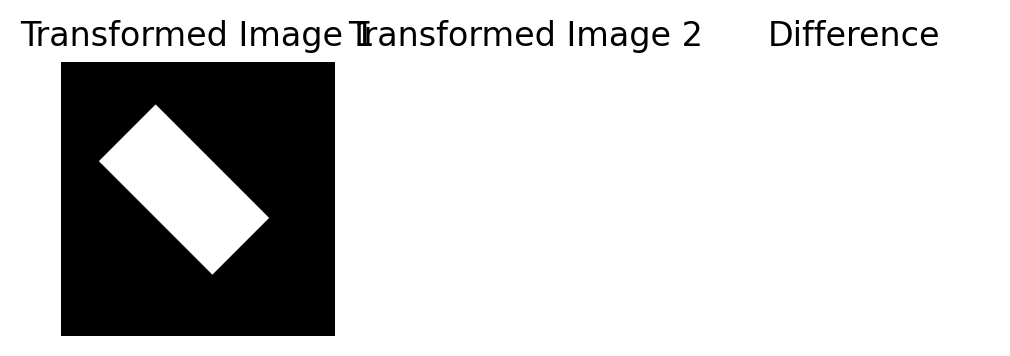

In [ ]:
transformed_image = rigid_transform(image, rigid_matrix)
transformed_image_my_interpolation = rigid_transform_my_interpolation(image, rigid_matrix)

print(transformed_image_my_interpolation)


plt.figure(dpi=200)

plt.subplot(1, 3, 1)
plt.imshow(transformed_image, cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Transformed Image 1")

plt.subplot(1, 3, 2)
plt.imshow(transformed_image_my_interpolation, cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Transformed Image 2")

plt.subplot(1, 3, 3)
plt.imshow(np.abs(transformed_image - transformed_image_my_interpolation), cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Difference")

plt.show()

Ostatnim zadaniem jest implementacja funkcji do transformacji lokalnej (0.5p). Zaimplementuj funkcję (wykorzystaj własną funkcję do interpolacji) i wygeneruj losowe pole przemieszczeń, np:

In [ ]:
def local_transform(image, u_x, u_y):
    """
    image - obraz do transformacji (YxX)
    u_x - pole przemieszczeń po kolumnach (YxX)
    u_y - pole przemieszczeń po wierszach (YxX)
    """

    #???
    # TO DO
    return image

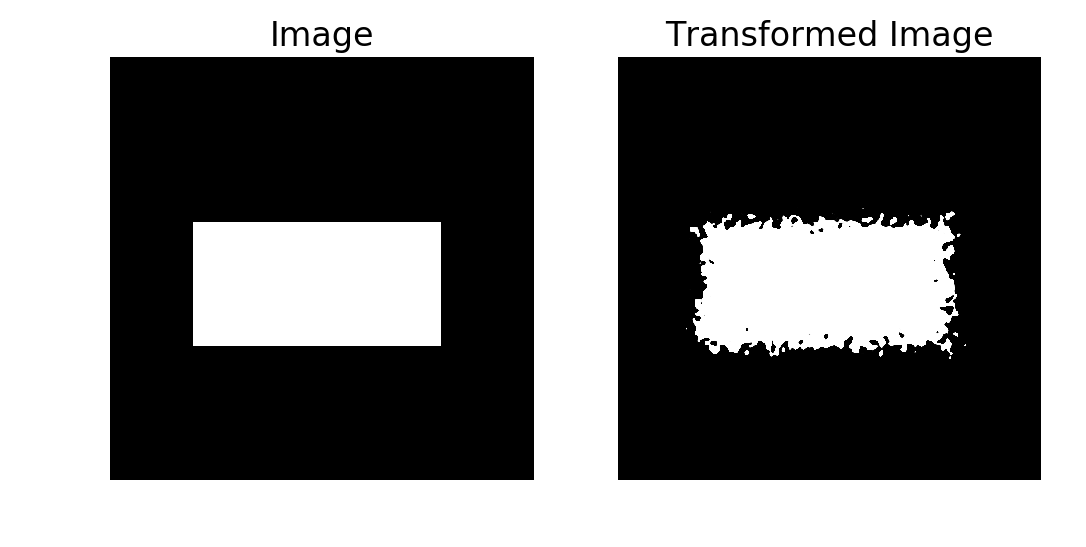

In [ ]:
np.random.seed(5)

u_x, u_y = np.random.randn(y_size, x_size)*250, np.random.randn(y_size, x_size)*250
u_x, u_y = nd.gaussian_filter(u_x, 5), nd.gaussian_filter(u_y, 5)
nonrigid_transformed_image = local_transform(image, u_x, u_y)

plt.figure(dpi=200)

plt.subplot(1, 2, 1)
plt.imshow(image, cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(nonrigid_transformed_image, cmap="gray", vmin=0, vmax=1)
plt.axis('off')
plt.title("Transformed Image")

plt.show()
